**Important: This notebook will only work with fastai-0.7.x. Do not try to run any fastai-1.x code from this path in the repository because it will load fastai-0.7.x**

# Random Forest Model interpretation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [3]:
set_plot_sizes(12,14,16)

## Load in our data from last lesson

In [4]:
PATH = "data/bulldozers/"

df_raw = pd.read_feather('tmp/bulldozers-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [5]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [6]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [7]:
df_raw

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,2,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,2,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,0,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,0,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,1,S175,...,23,3,204,False,False,False,False,False,False,1248307200
5,1139255,10.184900,1001274,4605,121,3.0,2004,508.0,2,310G,...,18,3,353,False,False,False,False,False,False,1229558400
6,1139256,9.952278,772701,1937,121,3.0,1993,11540.0,0,790ELC,...,26,3,239,False,False,False,False,False,False,1093478400
7,1139261,10.203592,902002,3539,121,3.0,2001,4883.0,0,416D,...,17,3,321,False,False,False,False,False,False,1132185600
8,1139272,9.975808,1036251,36003,121,3.0,2008,302.0,2,430HAG,...,27,3,239,False,False,False,False,False,False,1251331200
9,1139275,11.082143,1016474,3883,121,3.0,1000,20700.0,1,988B,...,9,3,221,False,False,False,False,False,False,1186617600


# Confidence based on tree variance

For model interpretation, there's no need to use the full dataset on each tree - using a subset will be both faster, and also provide better interpretability (since an overfit model will not provide much variance across trees).

In [8]:
set_rf_samples(50000)

In [9]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2066539595258113, 0.2499123168240218, 0.9107471099234155, 0.8884618863557869, 0.8935787881268142]


We saw how the model averages predictions across the trees to get an estimate - but how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions, instead of just the mean. This tells us the *relative* confidence of predictions - that is, for rows where the trees give very different results, you would want to be more cautious of using those results, compared to cases where they are more consistent. Using the same example as in the last lesson when we looked at bagging:

In [10]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 2.04 s, sys: 55.6 ms, total: 2.1 s
Wall time: 2.1 s


(9.344284123273638, 0.4200416789059232)

When we use python to loop through trees like this, we're calculating each in series, which is slow! We can use parallel processing to speed things up:

In [11]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 114 ms, sys: 216 ms, total: 330 ms
Wall time: 528 ms


(9.344284123273638, 0.4200416789059232)

We can see that different trees are giving different estimates this this auction. In order to see how prediction confidence varies, we can add this into our dataset.

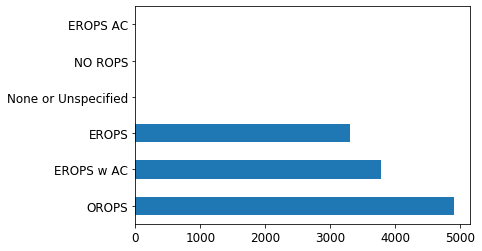

In [12]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

In [13]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.834632,0.275930
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.575211,0.263781
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.682551,0.220865


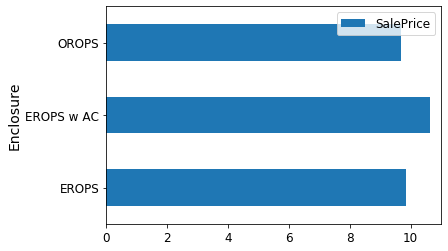

In [14]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

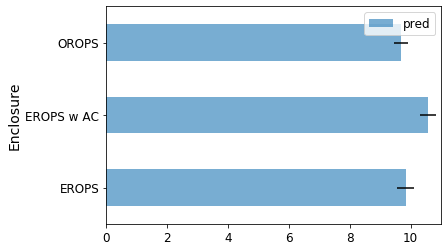

In [15]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));

*Question*: Why are the predictions nearly exactly right, but the error bars are quite wide?

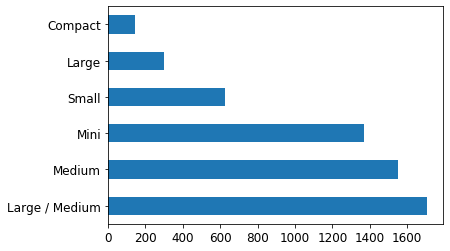

In [16]:
raw_valid.ProductSize.value_counts().plot.barh();

In [17]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.839703,0.344553
Large,10.470589,10.366490,0.370726
Large / Medium,10.691871,10.648649,0.298009
Medium,10.681511,10.613652,0.289398
Mini,9.535147,9.558680,0.246171
Small,10.324448,10.317959,0.306949


In [18]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Large             0.035762
Compact           0.035017
Small             0.029749
Large / Medium    0.027986
Medium            0.027267
Mini              0.025754
dtype: float64

# Feature importance

It's not normally enough to just to know that a model can make accurate predictions - we also want to know *how* it's making predictions. The most important way to see this is with *feature importance*.

In [19]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
5,YearMade,0.174654
37,Coupler_System,0.108632
13,ProductSize,0.097186
14,fiProductClassDesc,0.090481
39,Hydraulics_Flow,0.056629
2,ModelID,0.054669
63,saleElapsed,0.050651
10,fiSecondaryDesc,0.039705
38,Grouser_Tracks,0.039439
19,Enclosure,0.036389


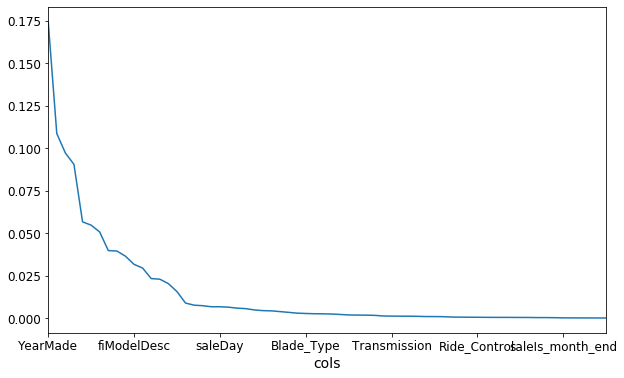

In [20]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [21]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

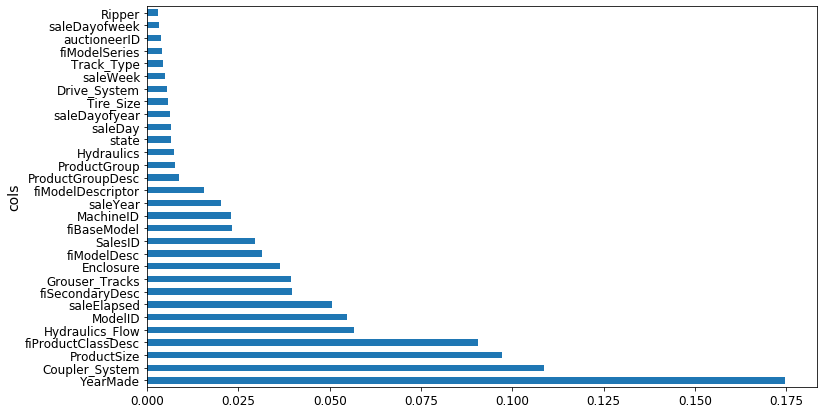

In [22]:
plot_fi(fi[:30]);

In [23]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

24

In [24]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [25]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20654759599925213, 0.2464574276066656, 0.9108389621105845, 0.8915244660721988, 0.8944928921002082]


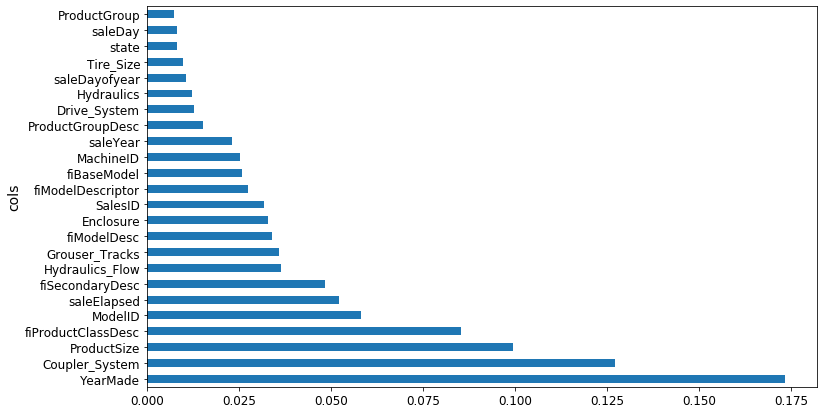

In [26]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

## One-hot encoding

proc_df's optional *max_n_cat* argument will turn some categorical variables into new columns.

For example, the column **ProductSize** which has 6 categories:

* Large
* Large / Medium
* Medium
* Compact
* Small
* Mini

gets turned into 6 new columns:

* ProductSize_Large
* ProductSize_Large / Medium
* ProductSize_Medium
* ProductSize_Compact
* ProductSize_Small
* ProductSize_Mini

and the column **ProductSize** gets removed.

It will only happen to columns whose number of categories is no bigger than the value of the *max_n_cat* argument.

Now some of these new columns may prove to have more important features than in the earlier situation, where all categories were in one column.

In [27]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20786778354970414, 0.2543378083673093, 0.9096955406913958, 0.8844766369666608, 0.8918436158349866]


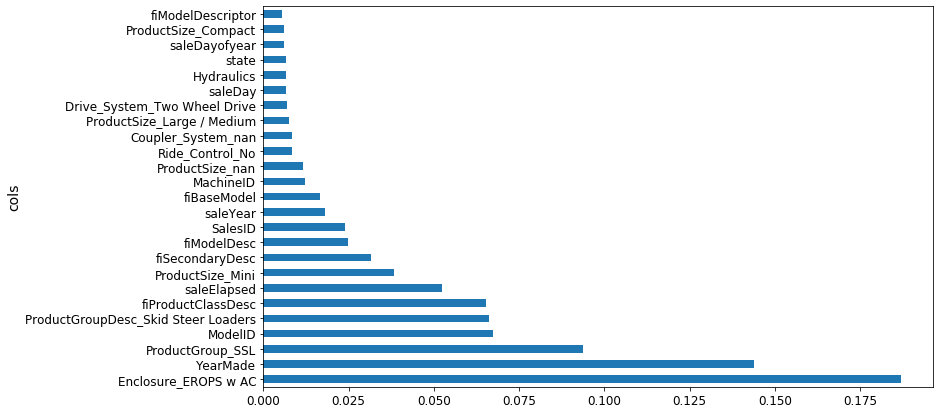

In [28]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

# Removing redundant features

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings. Let's try to remove redundent features.

In [29]:
from scipy.cluster import hierarchy as hc

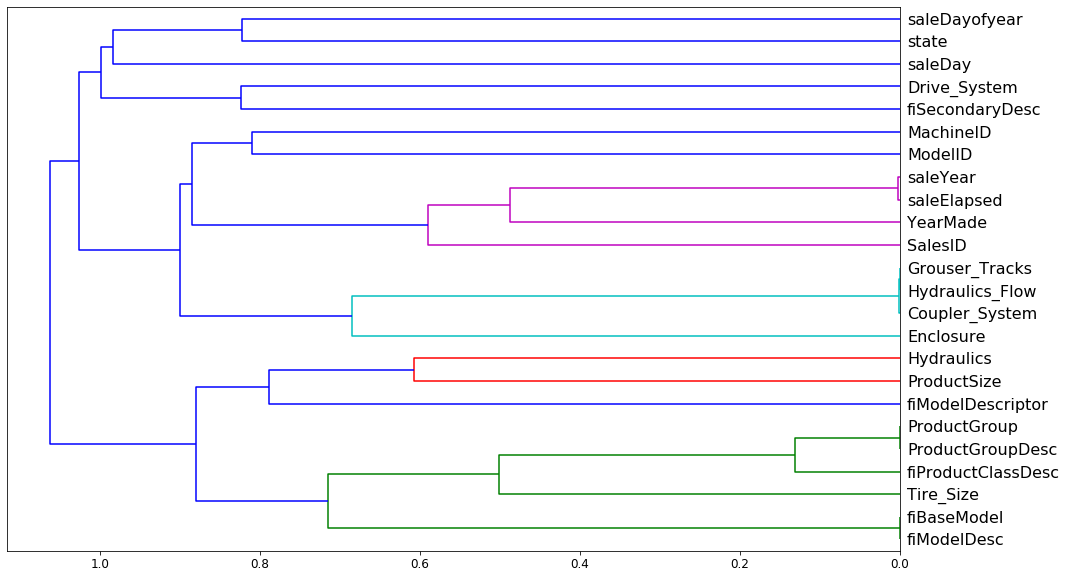

In [30]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

Let's try removing some of these related features to see if the model can be simplified without impacting the accuracy.

In [31]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

Here's our baseline.

In [32]:
get_oob(df_keep)

0.8900728351696978

Now we try removing each variable one at a time.

In [33]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.888964033014691
saleElapsed 0.8875226401284918
fiModelDesc 0.8885592811193311
fiBaseModel 0.8890166243472342
Grouser_Tracks 0.8898867202382167
Coupler_System 0.8903090967119324


It looks like we can try one from each group for removal. Let's see what that does.

In [34]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.8885724468077699

Looking good! Let's use this dataframe from here. We'll save the list of columns so we can reuse it later.

In [35]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [36]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [37]:
keep_cols = np.load('tmp/keep_cols.npy',allow_pickle=True)
df_keep = df_trn[keep_cols]

And let's see how this model looks on the full dataset.

In [38]:
reset_rf_samples()

## Using %prun [profile run]

In [39]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
%prun m.fit(X_train, y_train)
print_score(m)

 [0.12574067288908633, 0.2267915796186593, 0.9669564738025967, 0.9081452063624961, 0.9087385138854206]


# Partial dependence

In [40]:
from pdpbox import pdp
from plotnine import *

In [41]:
set_rf_samples(50000)

This next analysis will be a little easier if we use the 1-hot encoded categorical variables, so let's load them up again.

In [42]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

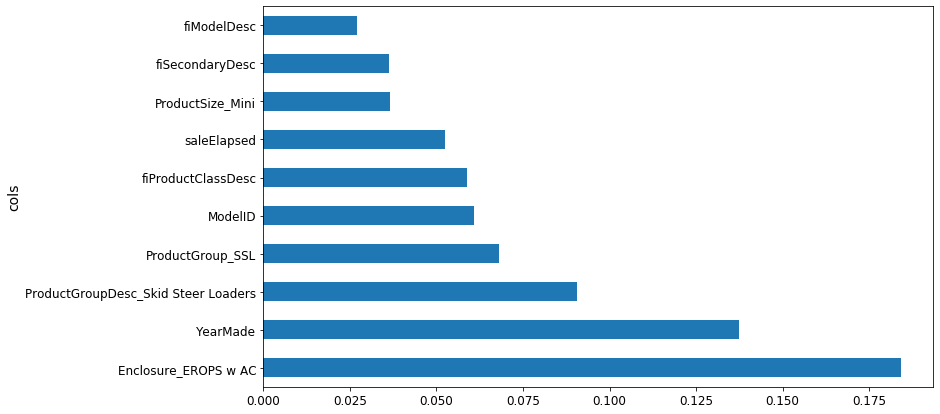

In [43]:
plot_fi(rf_feat_importance(m, df_trn2)[:10])

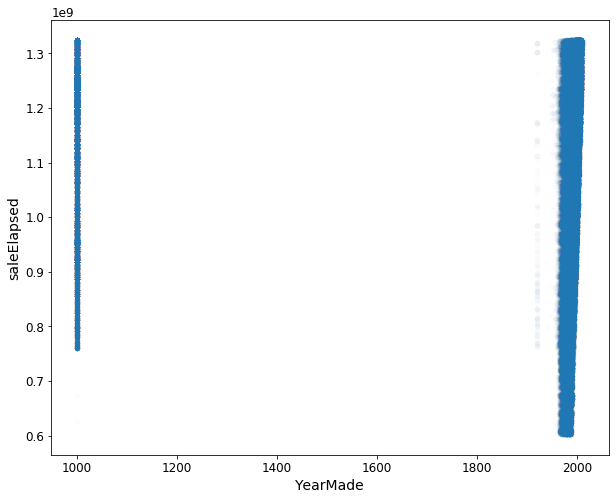

In [44]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

In [45]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)

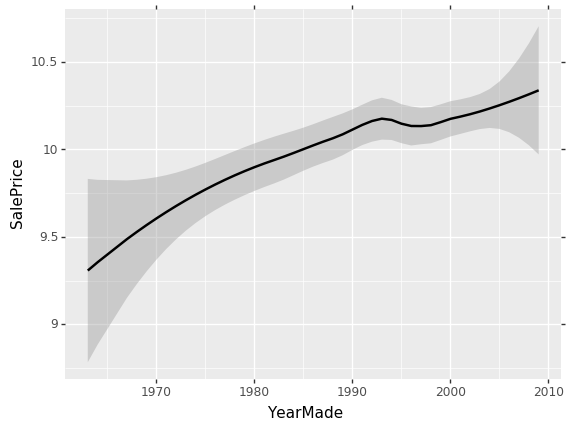

<ggplot: (-9223363288789168773)>

In [46]:
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess')

In [47]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

In [48]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


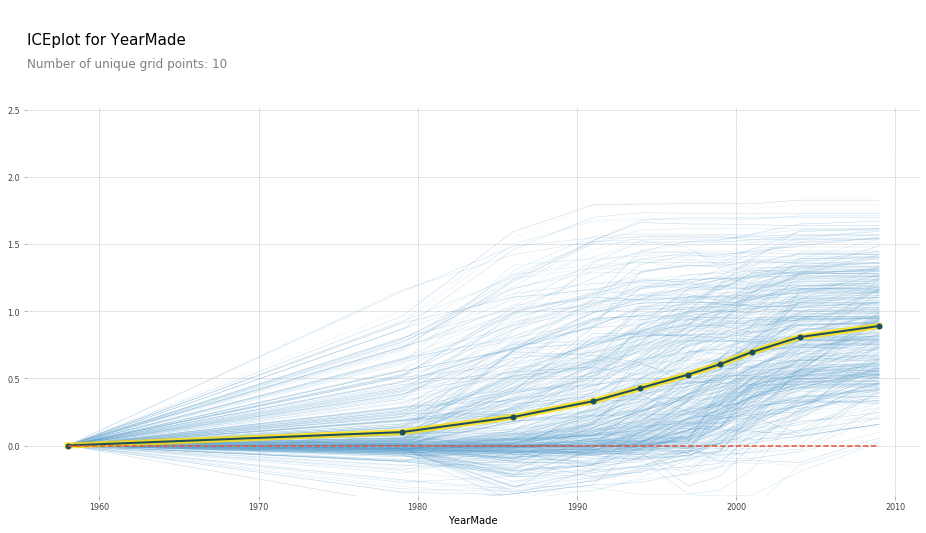

In [49]:
plot_pdp('YearMade')

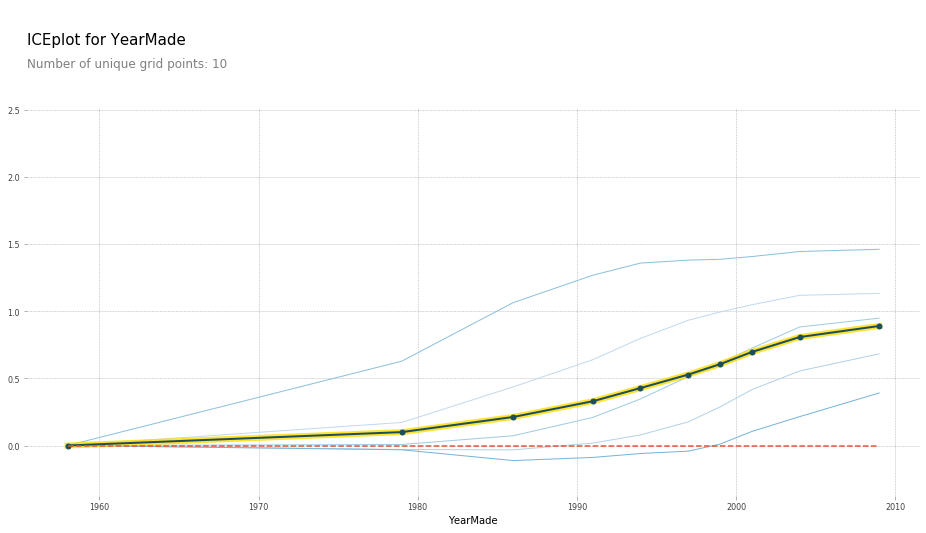

In [50]:
plot_pdp('YearMade', clusters=5)

TypeError: clabel() got an unexpected keyword argument 'contour_label_fontsize'

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


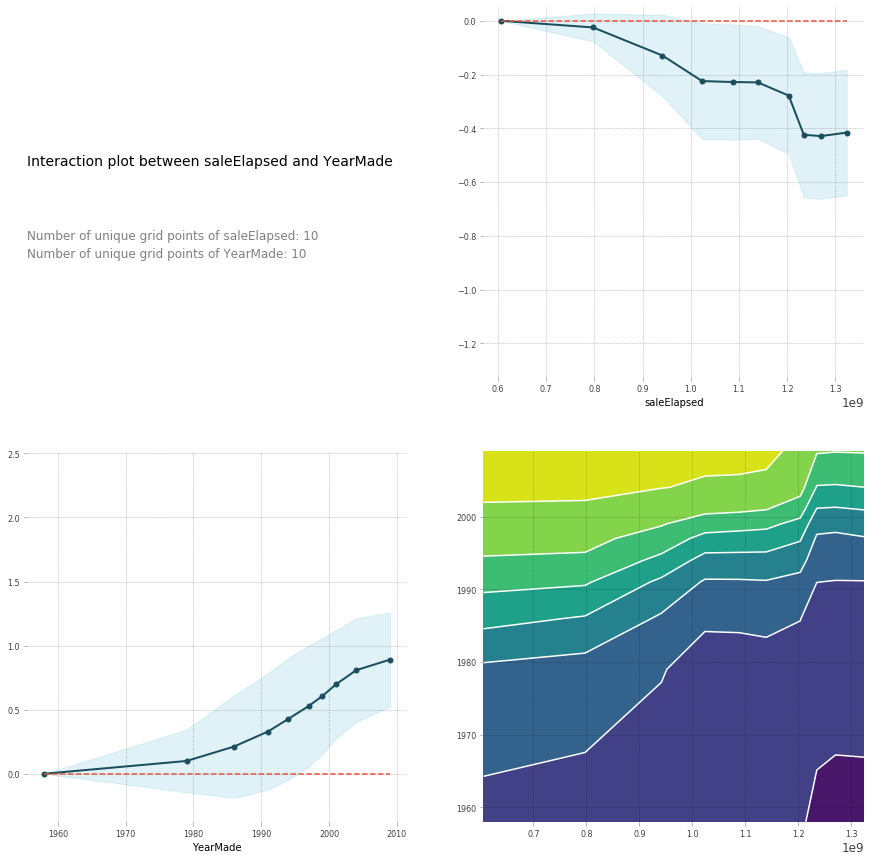

In [51]:
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x, feats)
pdp.pdp_interact_plot(p, feats)

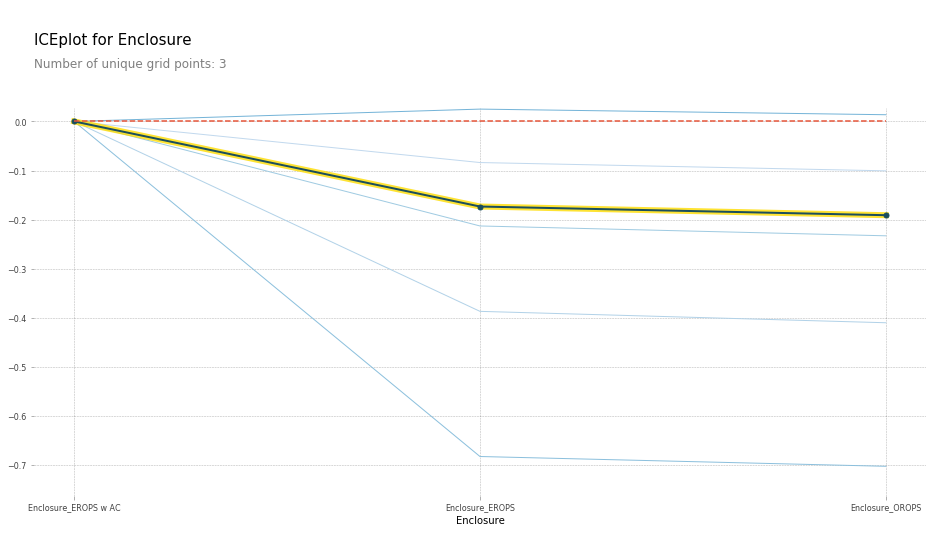

In [52]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')

In [53]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

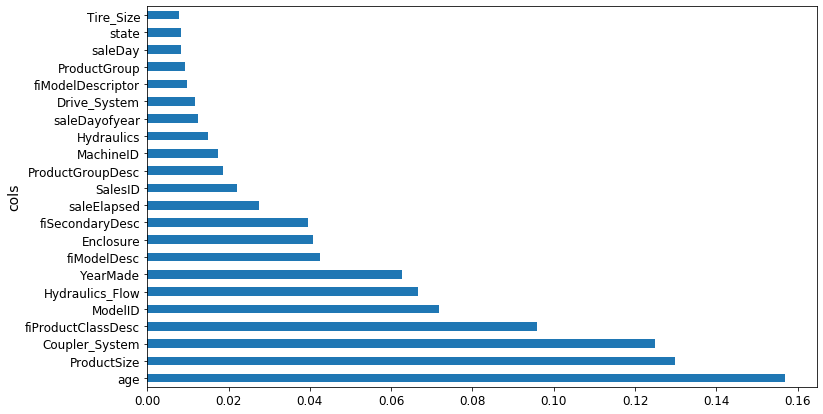

In [54]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep));

# Tree interpreter

In [55]:
from treeinterpreter import treeinterpreter as ti

In [56]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [57]:
row = X_valid.values[None,0]; row

array([[      1999,          0,          5,         17,          0,        665, 1284595200,          0,
                 1,       3232,    4364751,    2300944,          0,          4,          4,         12,
                35,         16,        259,          0,          0,         11]])

In [58]:
prediction, bias, contributions = ti.predict(m, row)

In [59]:
prediction.shape

(1, 1)

In [60]:
bias.shape

(1,)

In [61]:
contributions.shape

(1, 22)

In [62]:
contributions

array([[ 0.07787,  0.05761, -0.59262, -0.09846,  0.03142,  0.07765, -0.02894, -0.0546 , -0.03818, -0.09955,
        -0.02837,  0.0239 , -0.02605,  0.01623,  0.00529,  0.01642, -0.00169,  0.00396, -0.00658, -0.02459,
         0.00561, -0.10055]])

In [63]:
prediction[0], bias[0]

(array([9.32078]), 10.105009828802455)

In [64]:
idxs = np.argsort(contributions[0])

In [65]:
idxs

array([ 2, 21,  9,  3,  7,  8,  6, 10, 12, 19, 18, 16, 17, 14, 20, 13, 15, 11,  4,  1,  5,  0])

In [66]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('ProductSize', 'Mini', -0.5926218451080848),
 ('age', 11, -0.10055019345161456),
 ('fiModelDesc', 'KX1212', -0.09955282726068866),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -0.09845858248098897),
 ('fiSecondaryDesc', nan, -0.054597895456611846),
 ('Enclosure', 'EROPS', -0.038179753252228596),
 ('saleElapsed', 1284595200, -0.02894354148428522),
 ('SalesID', 4364751, -0.02836813692292397),
 ('fiModelDescriptor', nan, -0.026049507021031815),
 ('Tire_Size', nan, -0.024586925970238836),
 ('saleDayofyear', 259, -0.006583616851660601),
 ('state', 'Ohio', -0.0016908507949171092),
 ('saleDay', 16, 0.003964994510865072),
 ('ProductGroup', 'TEX', 0.0052915432306440465),
 ('Drive_System', nan, 0.005608214692087987),
 ('ProductGroupDesc', 'Track Excavators', 0.016228516731086273),
 ('Hydraulics', 'Standard', 0.016417313738411023),
 ('MachineID', 2300944, 0.023903220005911184),
 ('Hydraulics_Flow', nan, 0.0314184985072552),
 ('Coupler_System', nan, 0.057608

In [67]:
contributions[0].sum()

-0.7842249998785832

# Extrapolation

In [68]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

In [69]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9999925210345902

In [70]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
10,SalesID,0.767009
6,saleElapsed,0.147986
11,MachineID,0.069308
0,YearMade,0.004693
18,saleDayofyear,0.003786
5,ModelID,0.002263
9,fiModelDesc,0.001768
1,Coupler_System,0.001127
7,fiSecondaryDesc,0.000556
15,Hydraulics,0.000446


In [71]:
feats=['SalesID', 'saleElapsed', 'MachineID']

In [72]:
(X_train[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,389125.000000,3.891250e+05,389125.000000
mean,1800.452485,1.084797e+06,1206.796148
std,595.627288,1.803913e+05,430.850552
min,1139.246000,6.009984e+05,0.000000
25%,1413.348000,9.666432e+05,1087.016000
50%,1632.093000,1.134605e+06,1273.859000
75%,2210.453000,1.234138e+06,1458.661000
max,4364.741000,1.325117e+06,2313.821000


In [73]:
(X_valid[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,12000.000000,1.200000e+04,12000.000000
mean,5786.967651,1.306609e+06,1578.049709
std,836.899608,2.497808e+04,589.497173
min,4364.751000,1.174522e+06,0.830000
25%,4408.580750,1.309219e+06,1271.225250
50%,6272.538500,1.316045e+06,1825.317000
75%,6291.792250,1.321402e+06,1907.858000
max,6333.342000,1.325203e+06,2486.330000


In [74]:
x.drop(feats, axis=1, inplace=True)

In [75]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9789791212215644

In [76]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
18,age,0.234927
0,YearMade,0.190937
15,saleDayofyear,0.150509
5,ModelID,0.078259
8,fiModelDesc,0.062590
14,saleDay,0.058766
13,state,0.054695
3,fiProductClassDesc,0.032281
6,fiSecondaryDesc,0.023953
7,Enclosure,0.023187


In [77]:
set_rf_samples(50000)

In [78]:
feats=['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

In [79]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20773712407638506, 0.24853710800966441, 0.9098090303779558, 0.8896860450474717, 0.8932025379604588]


In [80]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

SalesID
[0.20909093347887678, 0.2454477560677344, 0.9086296624951478, 0.8924114372088794, 0.8924820463140208]
saleElapsed
[0.21426749757038224, 0.2549720647923405, 0.9040494604689517, 0.883899744398032, 0.8869856072854638]
MachineID
[0.20688340852275663, 0.24588015965174248, 0.9105488039716352, 0.8920320272737198, 0.894890727521049]
age
[0.20979118842099906, 0.2489618444999032, 0.9080166309349446, 0.8893086816974823, 0.8914415250414714]
YearMade
[0.2087119786528198, 0.2514269912424309, 0.9089605601818868, 0.8871057635426138, 0.892504173498581]
saleDayofyear
[0.20862532969185774, 0.24486068591525856, 0.9090361364418283, 0.8929254895550113, 0.8930117651360556]


In [81]:
reset_rf_samples()

In [82]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.13857359615284295, 0.218139736239765, 0.9598675381754699, 0.915019840605475, 0.9090978737994546]


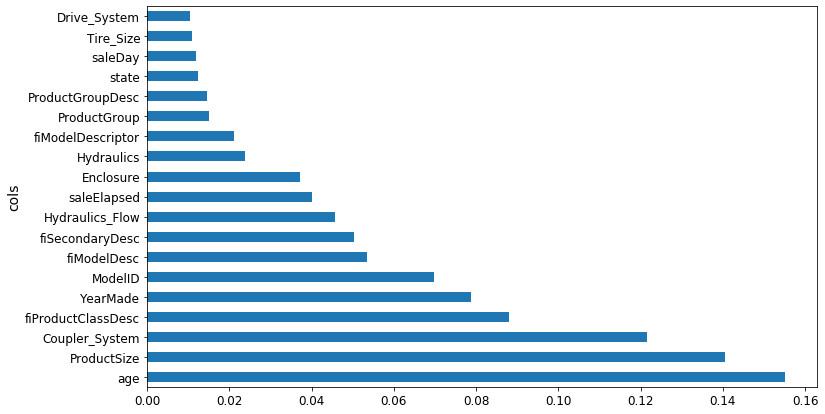

In [83]:
plot_fi(rf_feat_importance(m, X_train));

In [84]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

# Our final model!

In [85]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 6min, sys: 6.87 s, total: 6min 7s
Wall time: 35.6 s
[0.08018912824319609, 0.21159067585101415, 0.9865610353850012, 0.9200458472559094, 0.9144407791864956]
